# Course Code: DS4003 
# Course Name: Principles and Techniques for Data Science 
# Homework Assignment 3
# Due date: 6th December 2024
## Save the notebook with your name and submit it by the due date.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.holtwinters import ExponentialSmoothing



## Data overview

This dataset contains information on the quality of the air as measured by air quallity instruments for a period in time.


In [2]:
air_data = pd.read_csv(r'air_quality.csv')

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 1 (0.1pts)
    
### 1a: Determine whether the data needs any preprocessing. If so implement the appropriate functions to preprocess it.

</div>

In [3]:
## task 1a

# Checking for inconsistent encoding/datatypes 
datatypes = []
for _, row in air_data.iterrows():
    types=[type(variable) for variable in row]
    datatypes.append(types)

# Checking the encodings to see if some of them need to be changed
print(f'The has the following encodings: {datatypes[0]}. We can change the <str> types to <datetime>.\n')

reference = datatypes[0]
num_inconsistent_datatypes_rows=0
for row in datatypes:
    if row != reference:
        num_inconsistent_datatypes_rows+=1
print(f'Number of rows with inconsistens encodings: {num_inconsistent_datatypes_rows}\n')

# Checking for null entries
print(f'The dataset has no null entries: \n{air_data.isna().sum()}\n')

# Checking for negative values
print(f'Does the datsets numerical entries contain negative values? {(air_data.iloc[:, 2:] < 0).values.any()}. These need to be removed since they do not make sence in this context.\n')

# Checking for duplicate entries
print(f'The dataset has {air_data.duplicated().sum()} duplicate entries.\n')

# Checking for zeros replacing missing values
print(f'Does the datasets numerical values contain any 0 values? {(air_data.iloc[:, 2:] == 0).values.any()}')

The has the following encodings: [<class 'str'>, <class 'str'>, <class 'float'>, <class 'float'>]. We can change the <str> types to <datetime>.

Number of rows with inconsistens encodings: 0

The dataset has no null entries: 
Date           0
Time           0
NOx(GT)        0
PT08.S1(CO)    0
dtype: int64

Does the datsets numerical entries contain negative values? True. These need to be removed since they do not make sence in this context.

The dataset has 0 duplicate entries.

Does the datasets numerical values contain any 0 values? False


In [4]:
## task 1a

# Contatentating <str> dates and converting to <datetime>
def combine_date_and_time(df):
     df['Datetime'] = df['Date'] + ' ' + df['Time']
     df = df.drop(columns = ['Date', 'Time'])
     return df

air_data = combine_date_and_time(air_data)

def convert_to_datetime(string):
     return datetime.strptime(string, "%Y-%m-%d %H:%M:%S")

air_data = air_data.assign(Datetime=[convert_to_datetime(date) for date in air_data['Datetime']])

In [5]:
## task 1a

# Removing negative values
def drop_negatives(df):
    for index, row in df.iterrows():
        if any(value < 0 for value in row[['NOx(GT)', 'PT08.S1(CO)']]):
            df.drop(index=index, inplace=True)
    return df

air_data = drop_negatives(air_data)

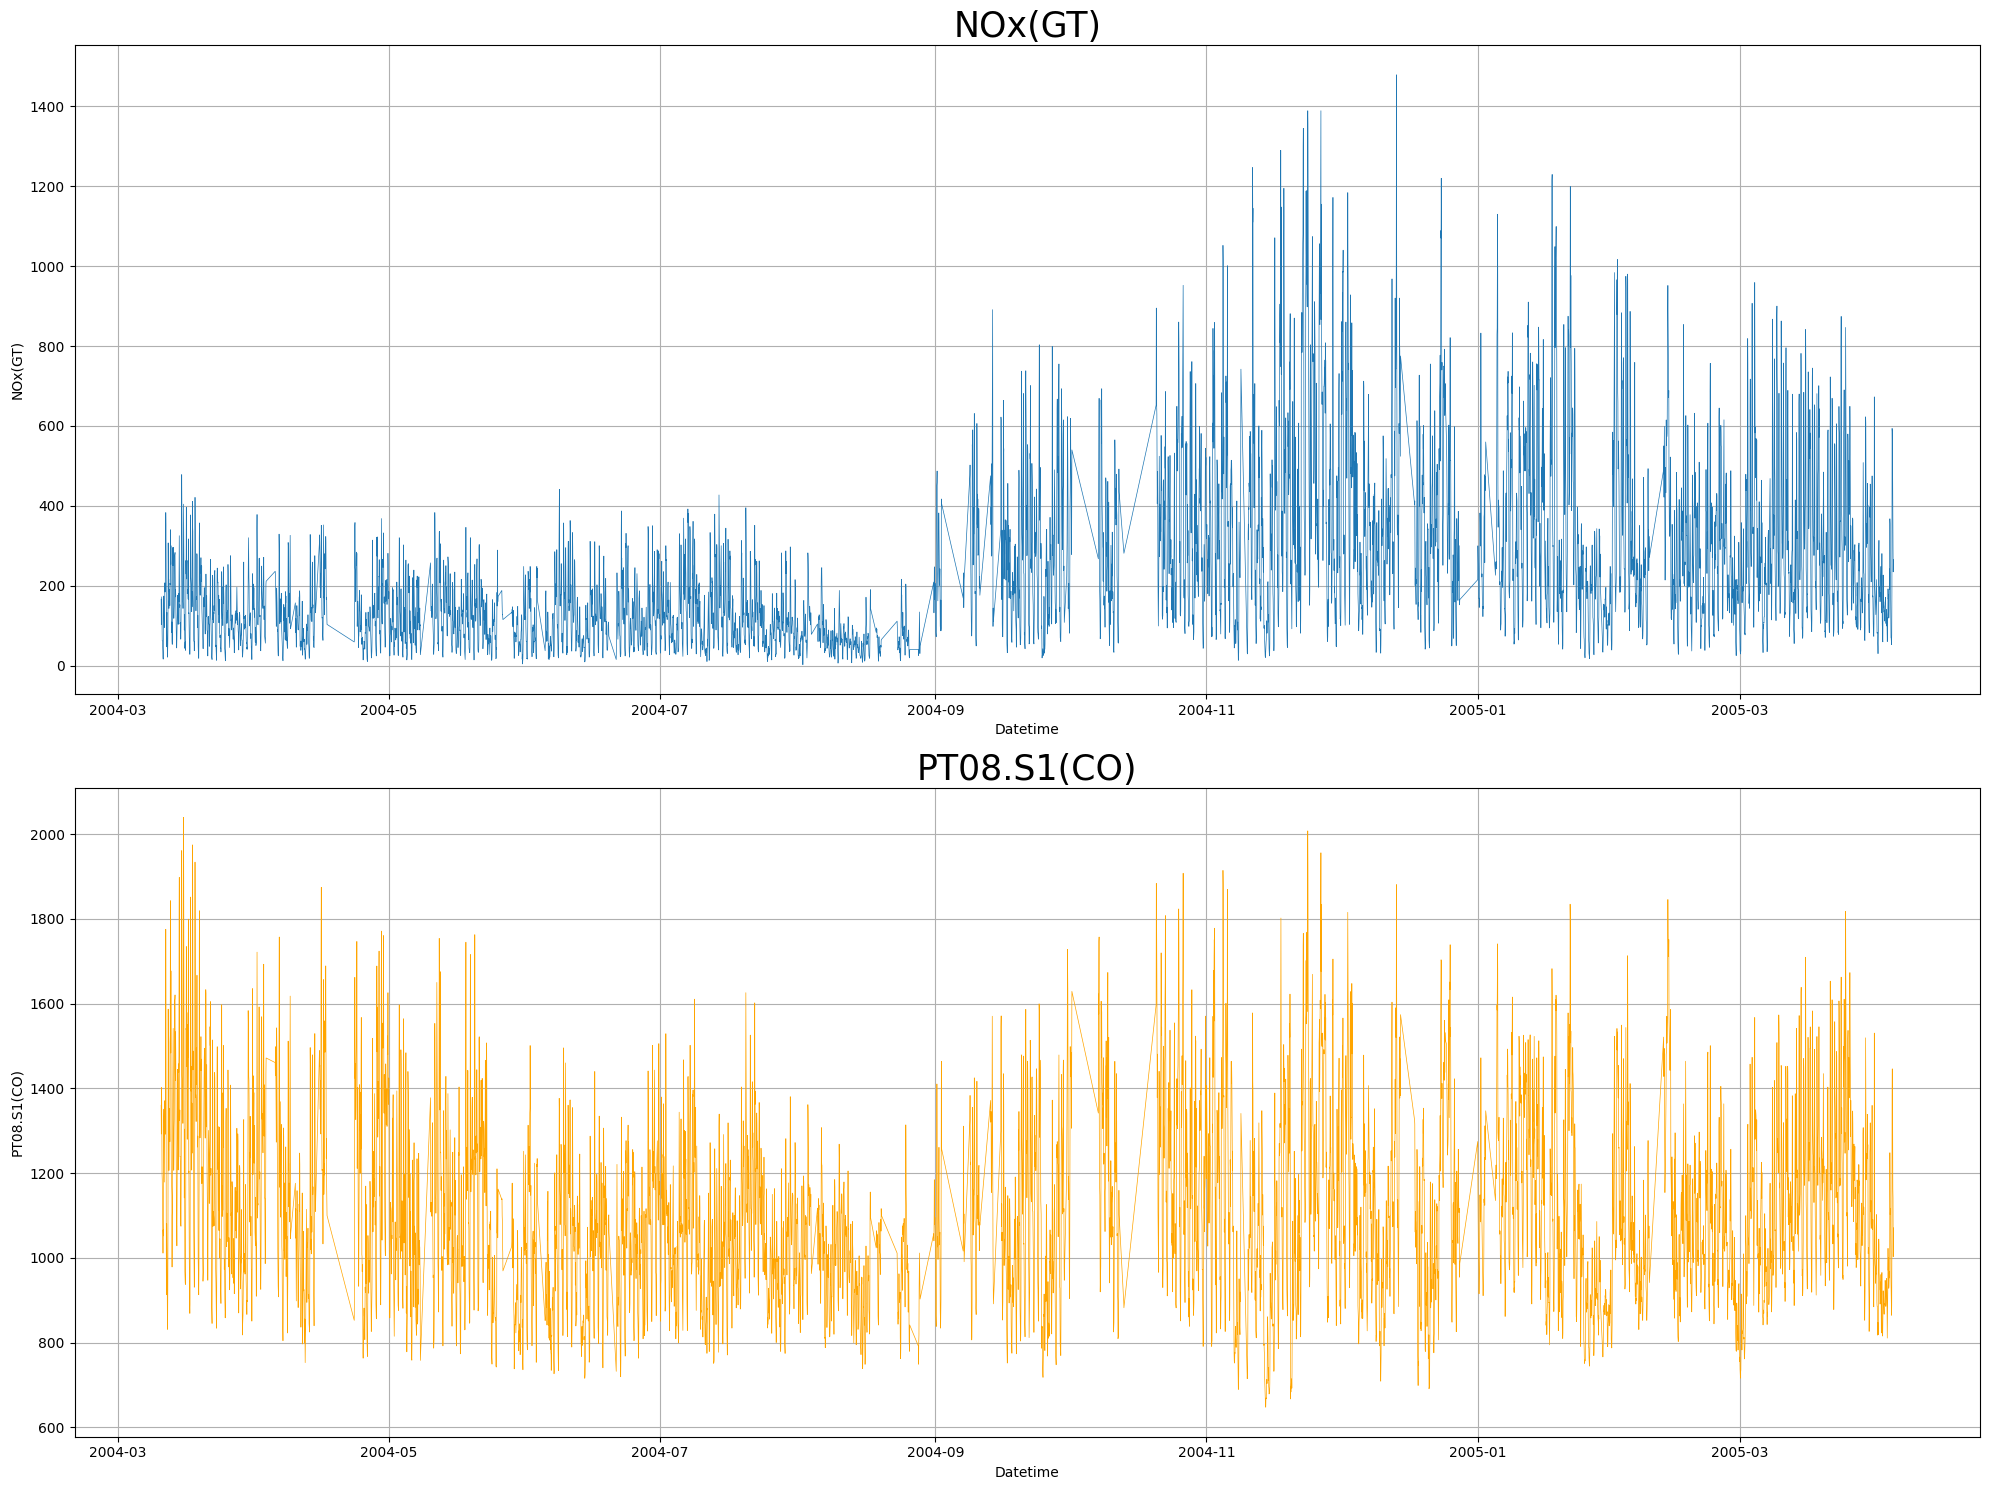

In [6]:
# plotting the timeseries to further analyze it
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

sns.lineplot(data=air_data, x='Datetime', y='NOx(GT)', ax=ax1, linewidth=0.5)
ax1.set_title('NOx(GT)', fontsize=25)
ax1.grid()

sns.lineplot(data=air_data, x='Datetime', y='PT08.S1(CO)', ax=ax2, linewidth=0.5, color='orange')
ax2.set_title('PT08.S1(CO)', fontsize=25)
ax2.grid()

plt.tight_layout()
plt.show()

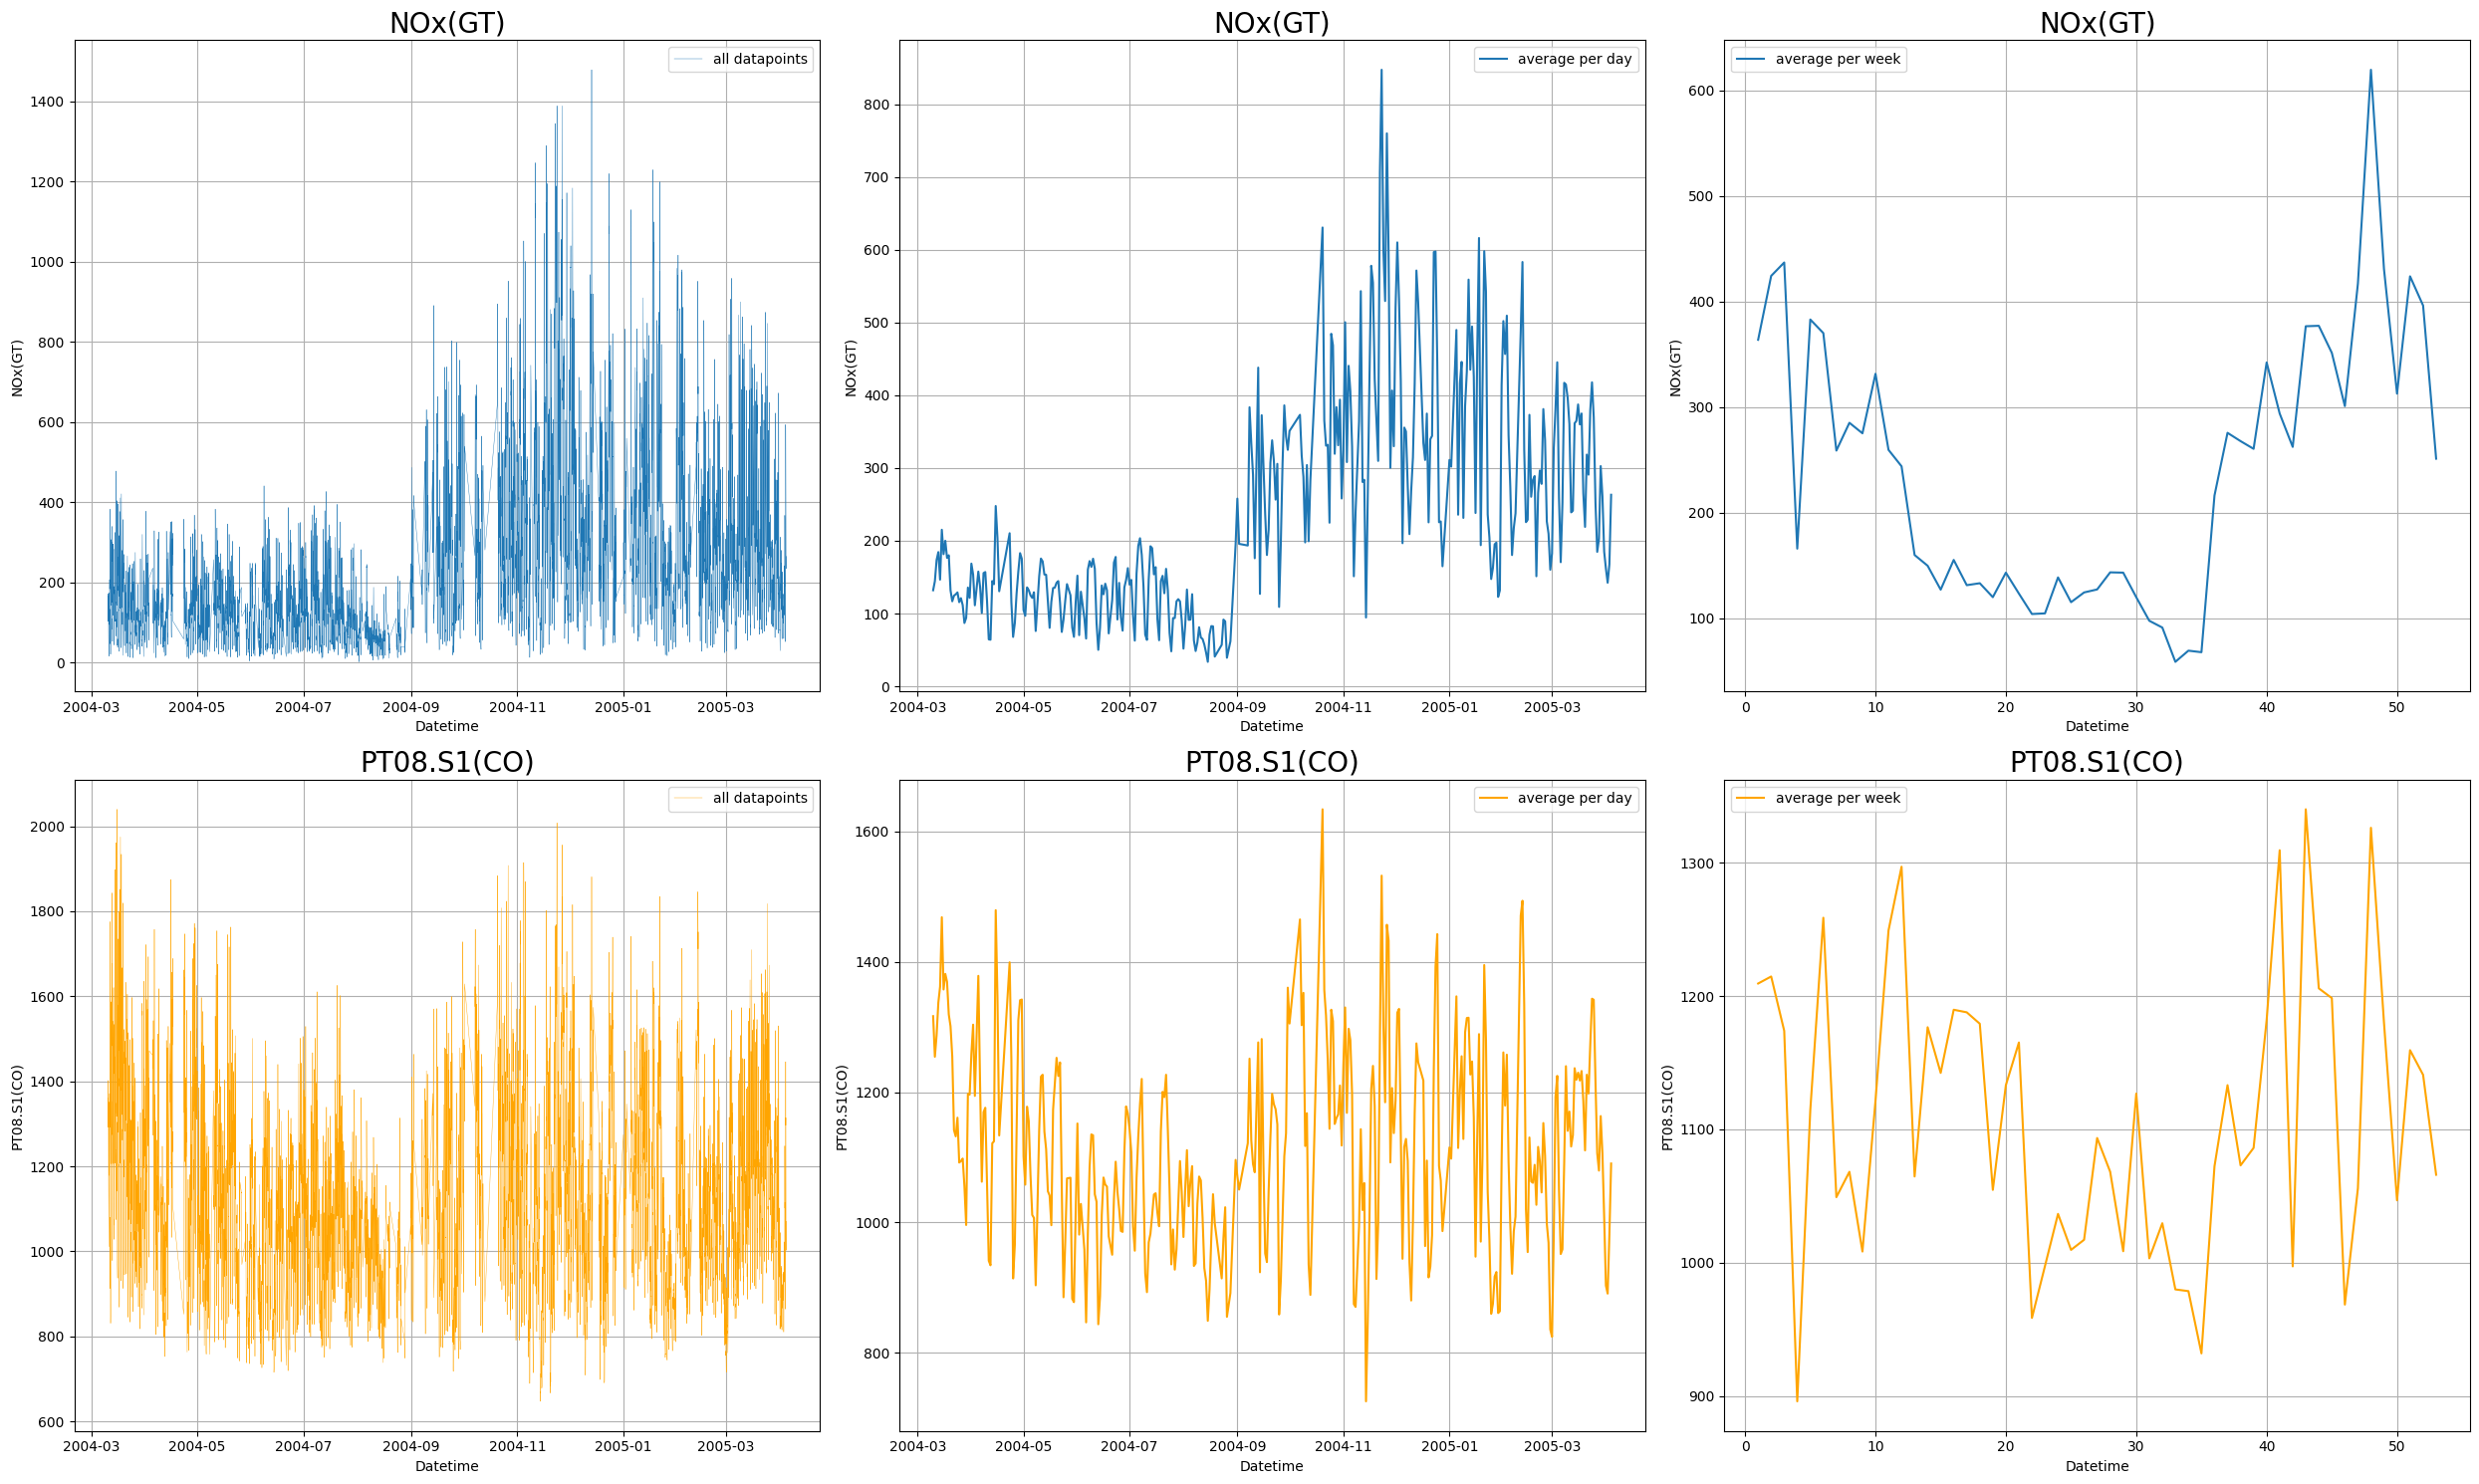

In [7]:
# Task 1a

# Based on the plots above, we can see that the timeseries is hard to interpret due to the given intervals between measurements. 
# Therefore, I am going to take the average entry per day and the average entry per week and compare the plots.

def averaging_to_days(df, variable_name):
    tmp_df = df.copy()
    tmp_df = tmp_df.assign(Datetime=[date.date() for date in tmp_df['Datetime']])
    agg = tmp_df.groupby(by='Datetime').mean()
    new_df = pd.DataFrame(data={'Datetime':agg.index, variable_name:agg.values.ravel()})
    return new_df

def averaging_to_weeks(df, variable_name): 
    tmp_df = df.copy()
    tmp_df = tmp_df.assign(Datetime=[date.isocalendar()[1] for date in tmp_df['Datetime']])
    agg = tmp_df.groupby(by='Datetime').mean()
    new_df = pd.DataFrame(data={'Datetime':agg.index, variable_name:agg.values.ravel()})
    return new_df

nox_series = air_data[['Datetime', 'NOx(GT)']]
nox_days = averaging_to_days(nox_series, 'NOx(GT)')
nox_weeks = averaging_to_weeks(nox_days, 'NOx(GT)')

pt08_series = air_data[['Datetime', 'PT08.S1(CO)']]
pt08_days = averaging_to_days(pt08_series, 'PT08.S1(CO)')
pt08_weeks = averaging_to_weeks(pt08_days, 'PT08.S1(CO)')

# Plotting
fig, ax = plt.subplots(2, 3, figsize = (25, 15))

sns.lineplot(data=air_data, x='Datetime', y='NOx(GT)', ax=ax[0, 0], linewidth=0.3, label='all datapoints')
sns.lineplot(data=nox_days, x='Datetime', y='NOx(GT)', ax=ax[0, 1], label='average per day')
sns.lineplot(data=nox_weeks, x='Datetime', y='NOx(GT)', ax=ax[0, 2], label='average per week')

ax[0, 0].set_title('NOx(GT)', fontsize=20)
ax[0, 1].set_title('NOx(GT)', fontsize=20)
ax[0, 2].set_title('NOx(GT)', fontsize=20)

ax[0, 0].grid()
ax[0, 1].grid()
ax[0, 2].grid()

sns.lineplot(data=air_data, x='Datetime', y='PT08.S1(CO)', ax=ax[1, 0], linewidth=0.3, label='all datapoints', color='Orange')
sns.lineplot(data=pt08_days, x='Datetime', y='PT08.S1(CO)', ax=ax[1, 1], label='average per day', color='Orange')
sns.lineplot(data=pt08_weeks, x='Datetime', y='PT08.S1(CO)', ax=ax[1, 2], label='average per week', color='Orange')

ax[1, 0].set_title('PT08.S1(CO)', fontsize=20)
ax[1, 1].set_title('PT08.S1(CO)', fontsize=20)
ax[1, 2].set_title('PT08.S1(CO)', fontsize=20)

ax[1, 0].grid()
ax[1, 1].grid()
ax[1, 2].grid()

plt.tight_layout()
plt.show()

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 2 (0.2pts)
### 2a: Break down the time series data to reveal its underlying components, such as general trends, recurring seasonal patterns, and any irregular fluctuations.
    
### 2b: Determine whether there are signs of significant shifts over time. Use an appropriate test to confirm the stationarity of the data and explain its implications for forecasting
</div>

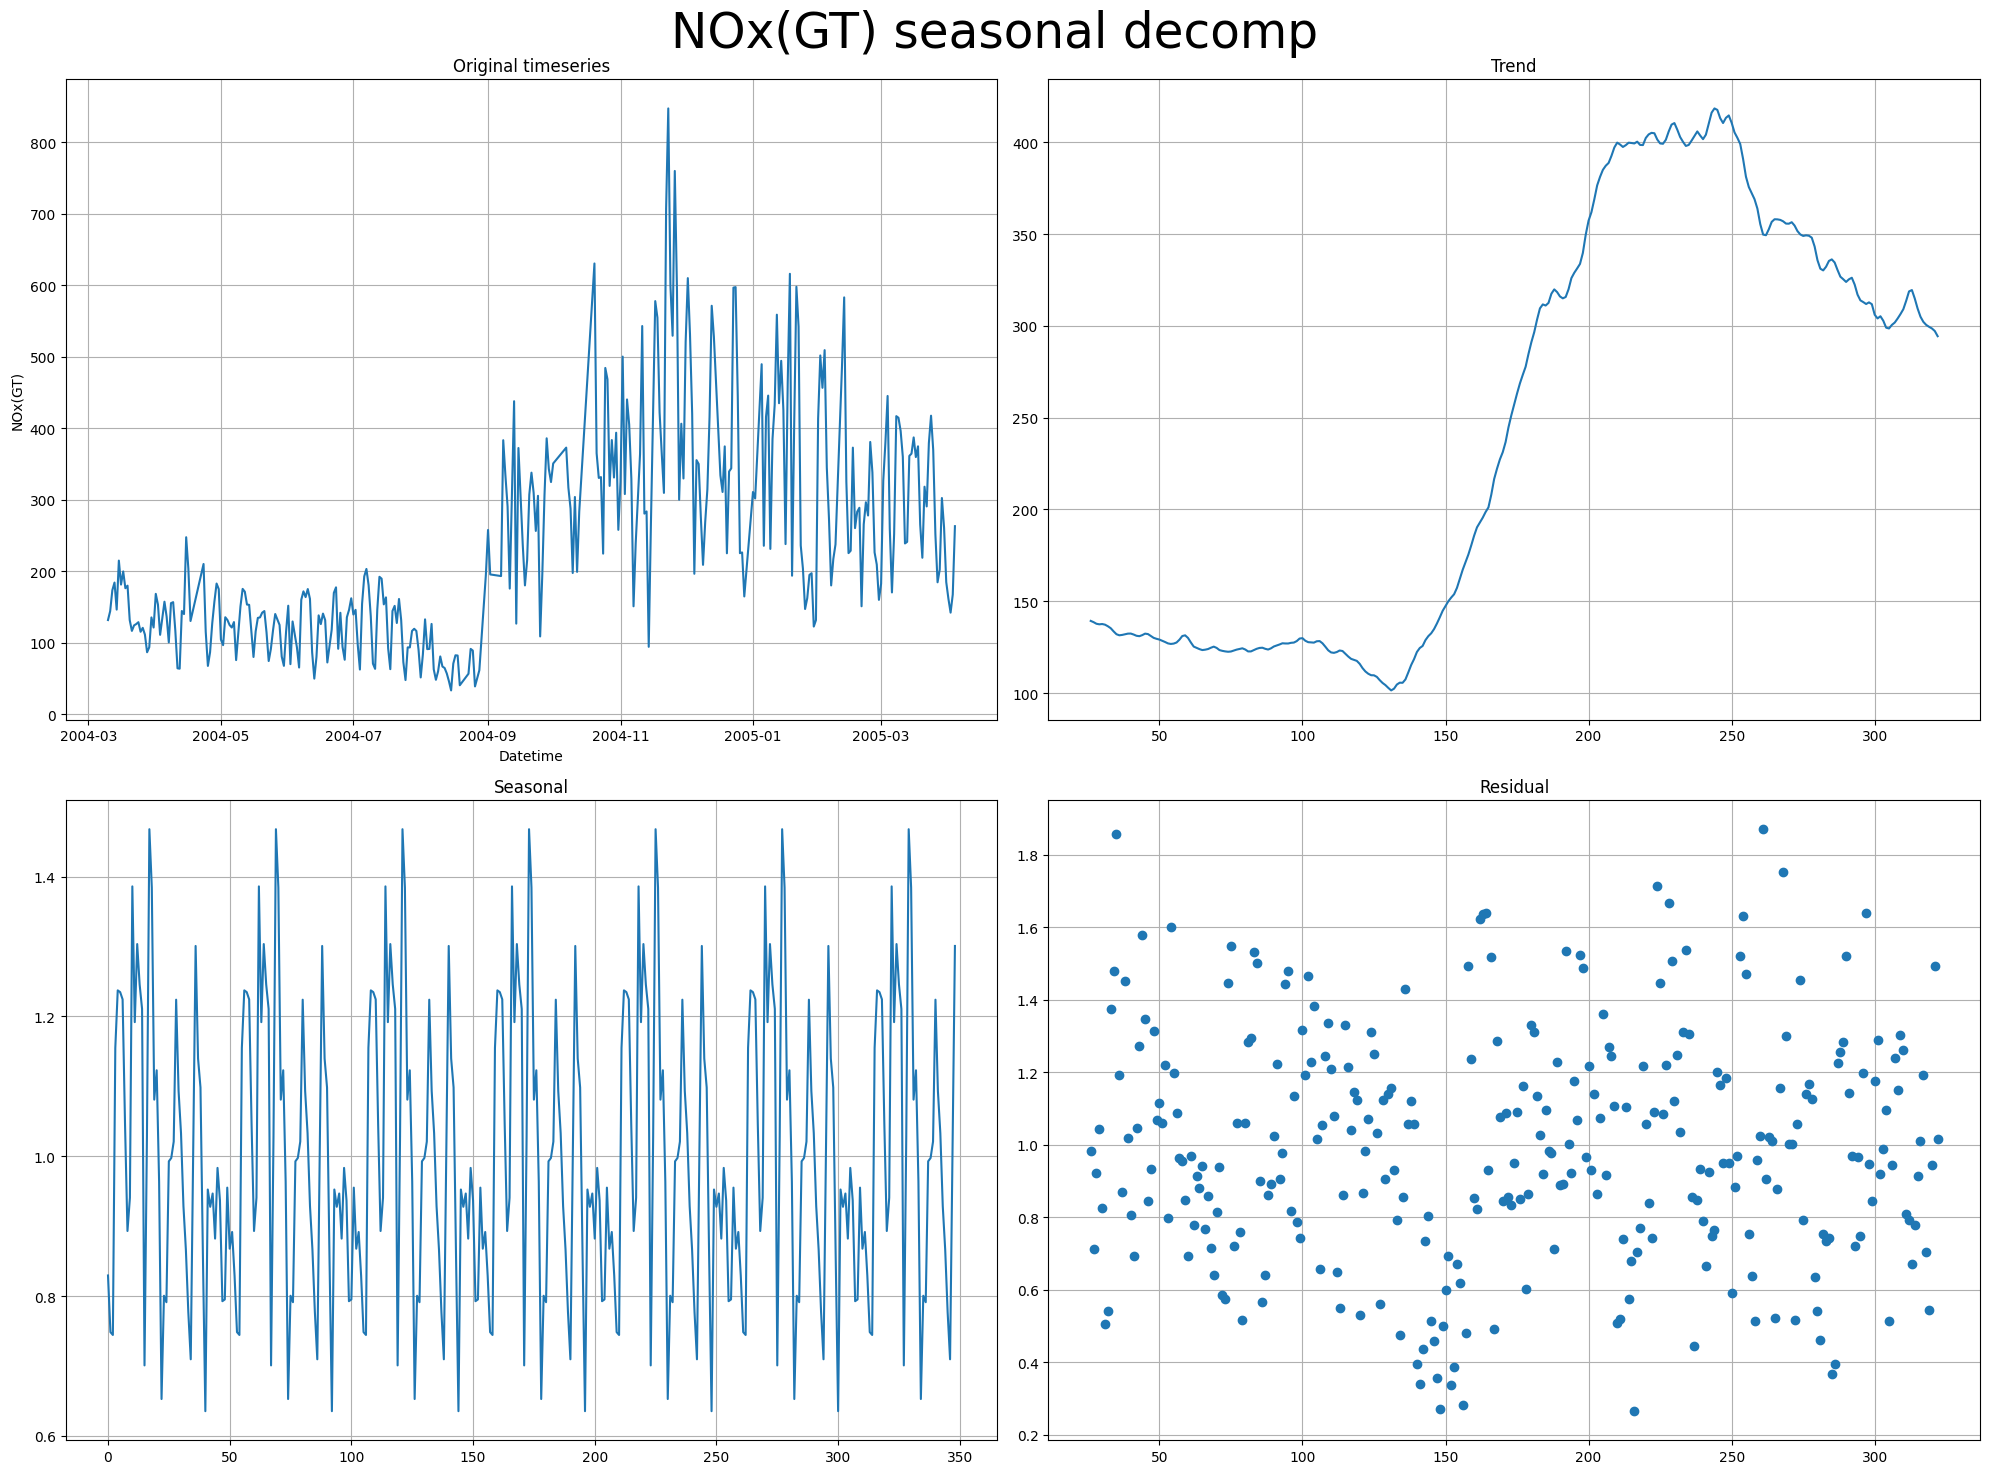

In [8]:
# Task 2a

# Applying seasonal decompotition with statsmodels.tsa
nox_decomp = seasonal_decompose(nox_days['NOx(GT)'], model='multiplicative', period=52)     # I choose multiplicative model here since the variance does not look to be constant for this variable

# Plotting'
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.lineplot(data=nox_days, x='Datetime', y='NOx(GT)', ax=ax[0, 0])
ax[0, 0].set_title('Original timeseries')
ax[0, 0].grid()

nox_decomp.trend.plot(ax=ax[0, 1])
ax[0, 1].set_title('Trend')
ax[0, 1].grid()

nox_decomp.seasonal.plot(ax=ax[1, 0])
ax[1, 0].set_title('Seasonal')
ax[1, 0].grid()

nox_decomp.resid.plot(marker='o', ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title('Residual')
ax[1, 1].grid()

fig.suptitle('NOx(GT) seasonal decomp', fontsize=35)

plt.tight_layout()
plt.show()

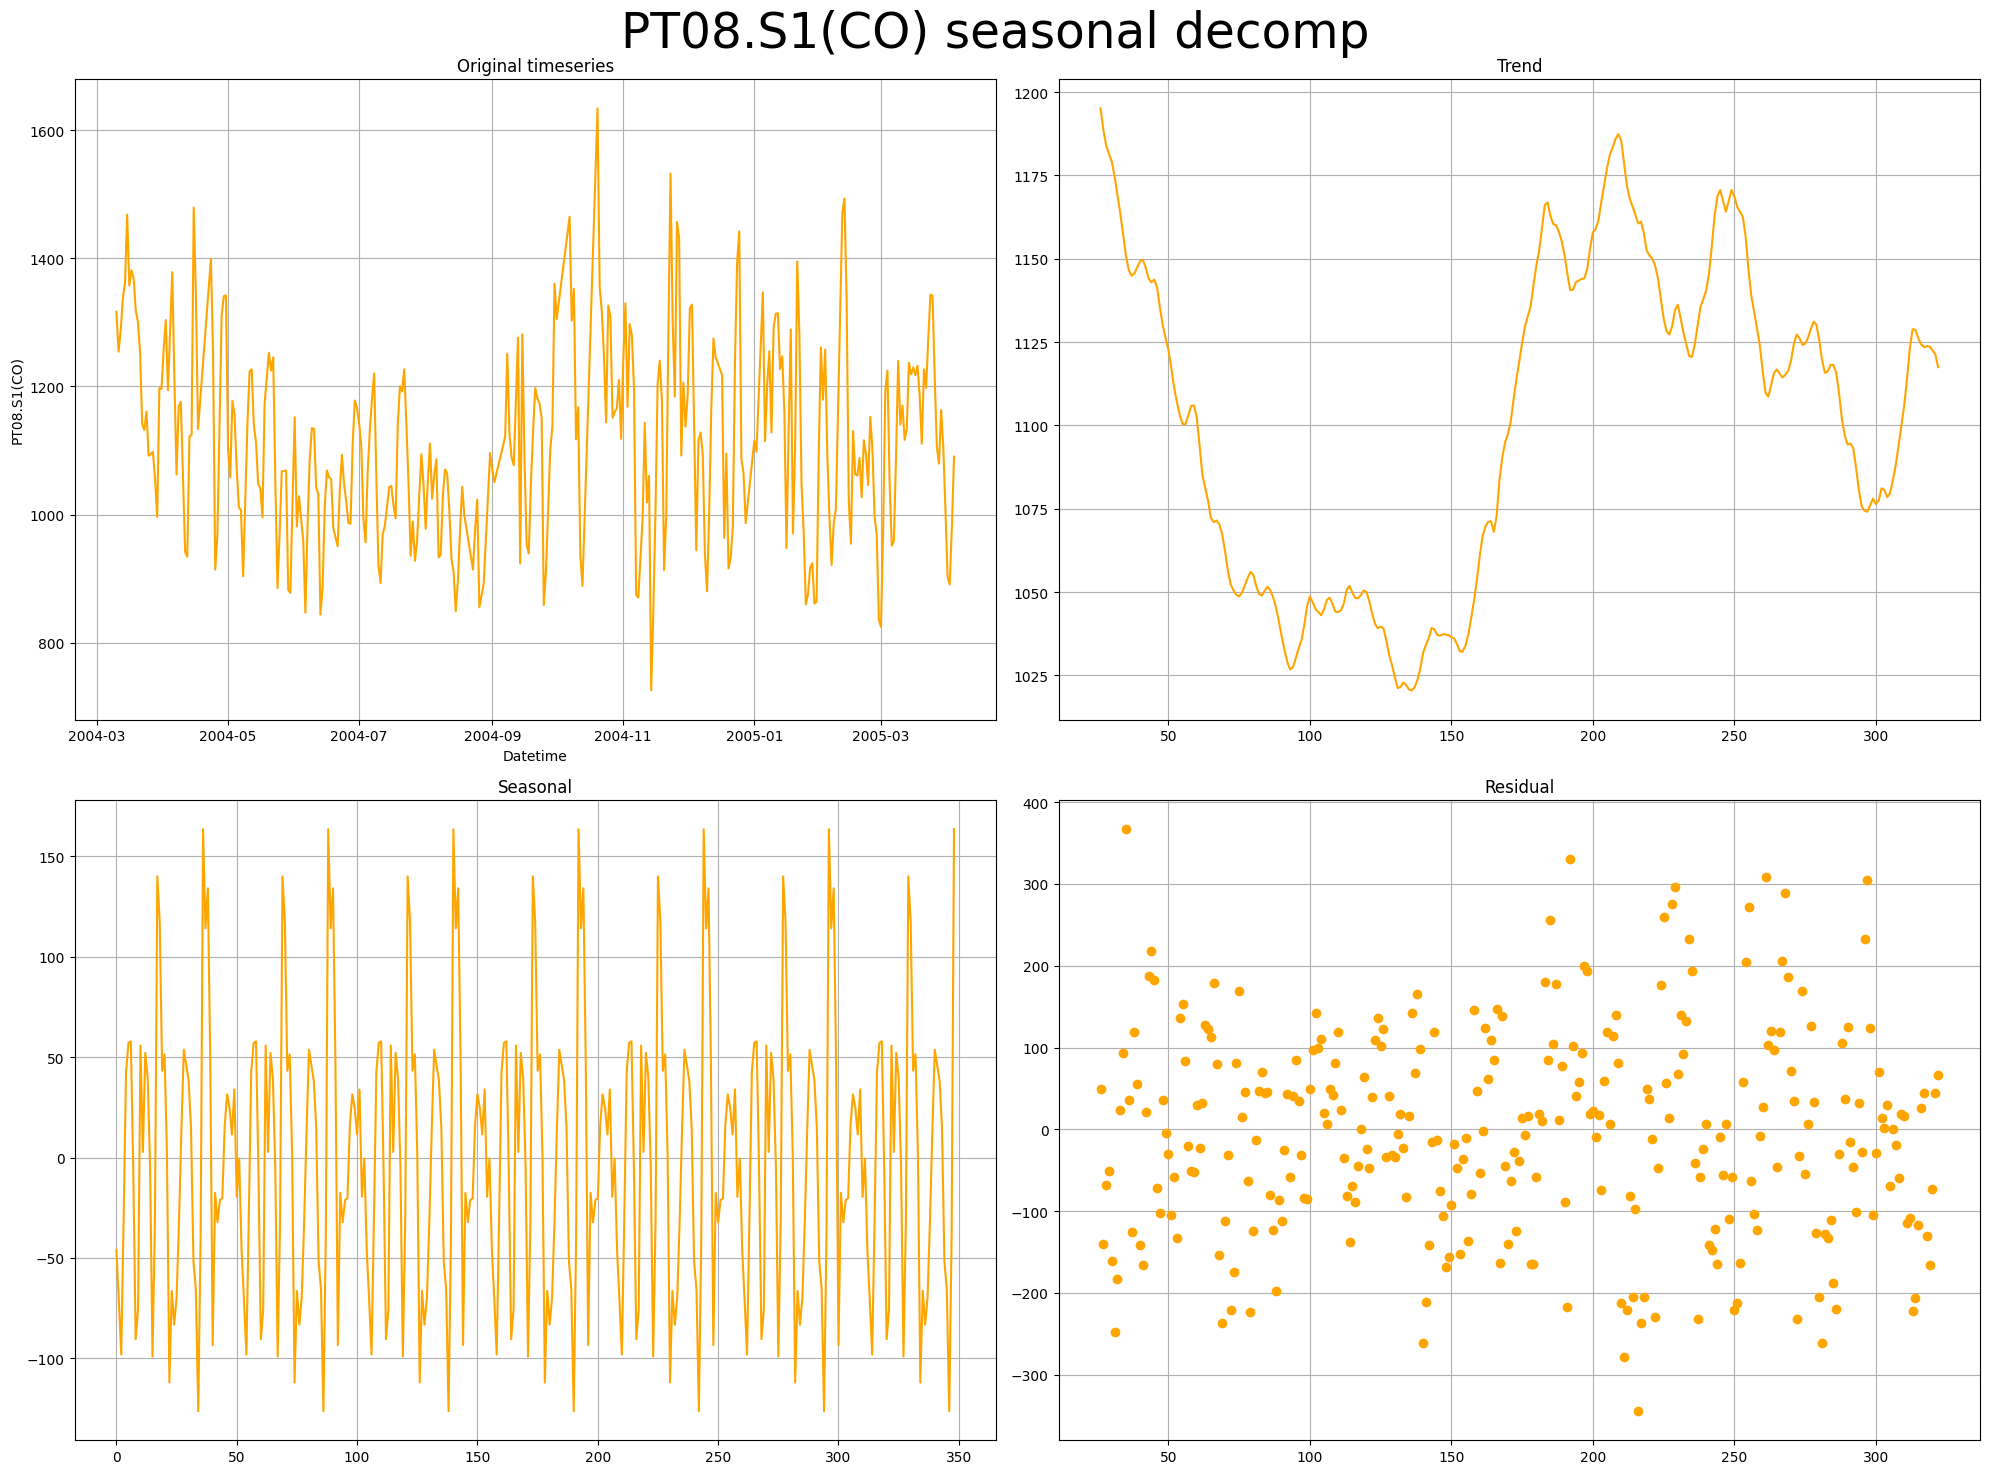

In [9]:
# Task 2a

# Applying seasonal decompotition with statsmodels.tsa
pt08_decomp = seasonal_decompose(pt08_days['PT08.S1(CO)'], model='additive', period=52)     # I choose additive model here since the variance looks to be constant for this variable

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.lineplot(data=pt08_days, x='Datetime', y='PT08.S1(CO)', ax=ax[0, 0], color='orange')
ax[0, 0].set_title('Original timeseries')
ax[0, 0].grid()

pt08_decomp.trend.plot(ax=ax[0, 1], color='orange')
ax[0, 1].set_title('Trend')
ax[0, 1].grid()

pt08_decomp.seasonal.plot(ax=ax[1, 0], color='orange')
ax[1, 0].set_title('Seasonal')
ax[1, 0].grid()

pt08_decomp.resid.plot(marker='o', ax=ax[1, 1], linewidth=0, color='orange')
ax[1, 1].set_title('Residual')
ax[1, 1].grid()

fig.suptitle('PT08.S1(CO) seasonal decomp', fontsize=35)

plt.tight_layout()
plt.show()

In [10]:
# Task 2b

# To chech if there are significant shifts over time (exluding visuial inspeciton) we can se the Agumented Dickey-Fuller test to see if the timeseries is stationary or not. 
# If the time series is stationary, its statistical properties such as mean, variance and trend are constant over time, which means they are not dependent on the time varible. 

p_reference = 0.05

nox_pvalue = adfuller(nox_series['NOx(GT)'])
print(f'p-value for the NOx variable is {nox_pvalue[1]}. Can we reject the null hypothesis? {p_reference > nox_pvalue[1]}\n')     # not stationary

pt08_pvalue = adfuller(pt08_series['PT08.S1(CO)'])
print(f'p-value for PT08 variable is {pt08_pvalue[1]}. Can we reject the null hypothesis? {p_reference > pt08_pvalue[1]}\n')     # not stationary

# This means that the timeseries can be considered stationary, which means that they are statisticaly apropriate for autoregressive and 
# moving average models, which on their own can not handle non-stationary time series. If we do not have a stationary timeseries, we can 
# remove components like trend and non-constant variance with methods such as logarithmic transformations, square-root transformations or Box-Cox transformations.

p-value for the NOx variable is 1.9834552557019766e-09. Can we reject the null hypothesis? True

p-value for PT08 variable is 1.5824145494426228e-15. Can we reject the null hypothesis? True



<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 3 (0.3pts)
### 3a: Forecast the values of the timeseries signals for the next 3 months from the last date. Use two different forecasting methods of your choice. 

### Evaluate the quality of your predictions and visualise the predictions from the different methods.  Which method seems more realistic based on the observed trends and patterns in the data?

</div>

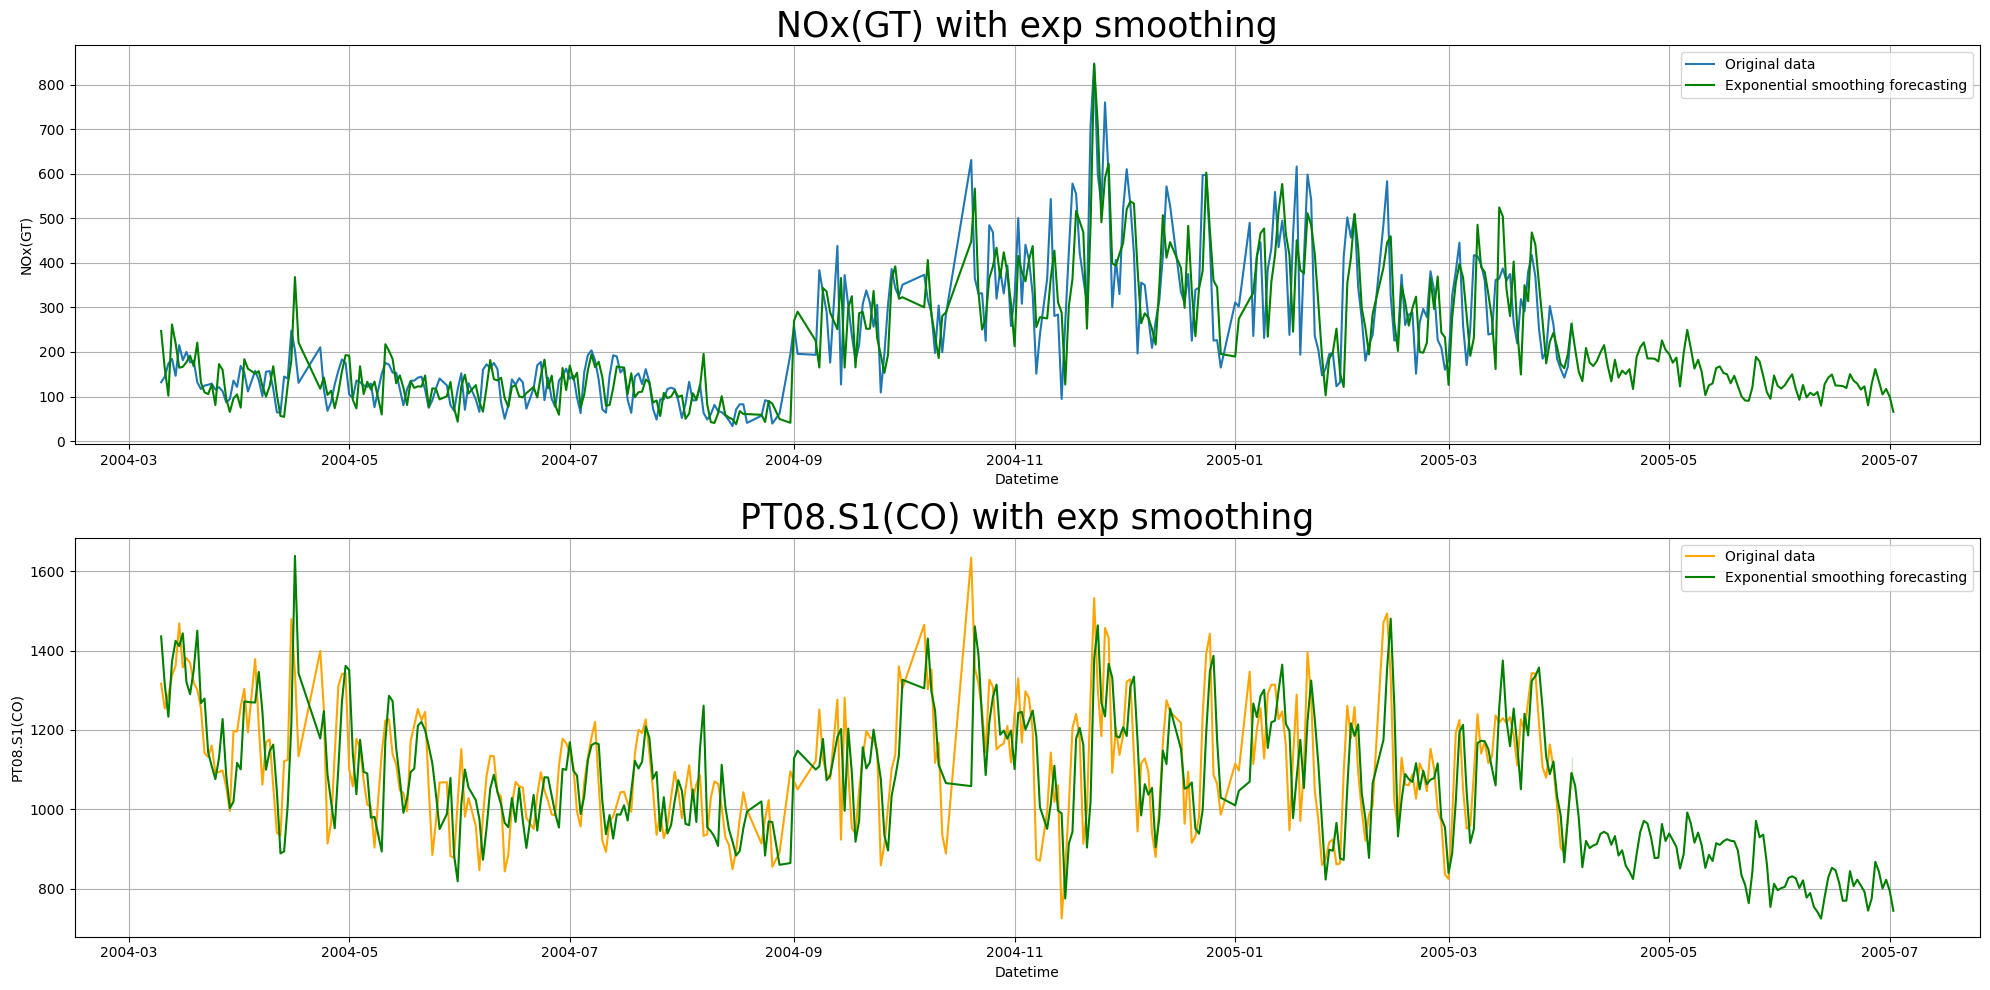

In [47]:
# Task 3a

# Method 1: Exponential smoothing

period = 90
date_range = pd.date_range(nox_days['Datetime'].iloc[-1], periods=period, freq='D').date
ext_dates = list(nox_days['Datetime'])+list(date_range)

nox_expsmooth_model = ExponentialSmoothing(nox_days['NOx(GT)'], trend='add', seasonal='mul', seasonal_periods=52).fit(smoothing_level=0.8)
nox_expsmooth_prediction = nox_expsmooth_model.predict(start=nox_days.index[0], end=nox_days.index[-1]+period)

pt08_expsmooth_model = ExponentialSmoothing(pt08_days['PT08.S1(CO)'], trend='add', seasonal='mul', seasonal_periods=52).fit(smoothing_level=0.8)
py08_expsmooth_prediction = pt08_expsmooth_model.predict(start=pt08_days.index[0], end=pt08_days.index[-1]+period)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(data=nox_days, x='Datetime', y='NOx(GT)', label='Original data', ax=ax1)
sns.lineplot(x=ext_dates, y=nox_expsmooth_prediction.values, label='Exponential smoothing forecasting', ax = ax1, color='green')
ax1.set_title('NOx(GT) with exp smoothing', fontsize=25)
ax1.grid()

sns.lineplot(data=pt08_days, x='Datetime', y='PT08.S1(CO)', label='Original data', ax=ax2, color='orange')
sns.lineplot(x=ext_dates, y=py08_expsmooth_prediction.values, label='Exponential smoothing forecasting', ax = ax2, color='green')
ax2.set_title('PT08.S1(CO) with exp smoothing', fontsize=25)
ax2.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Task 3a

# Method 1: SARIMA

model = auto_arima(train, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warning=True, stepwise=True)
model.fit(train)
pred = model.predict(n_periods=len(test))

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Task 4 (0.4pts)
### To understand the relationship between the variables in your dataset, your task is to build a model that captures this relationship using linear regression.
### 4a: Fit a linear regression model to your data. Derive the Coefficients Using OLS or Gradient Descent.
### 4b: Plot the regression line alongside the original data points to visually assess the fit of the model..

</div>

In [ ]:
## YOUR CODE HERE

<div class='alert alert-block alert-success' style="font-weight:bolder">

### Optional Task
### Transfrom the signals using PAA or SAX

</div>

In [ ]:
## Extra credit